In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import matplotlib.pyplot as plt

c:\Users\Nihan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

pip install textblob

     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
     - -------------------------------------- 30.7/636.8 kB ? eta -:--:--
     -- ---------------------------------- 41.0/636.8 kB 991.0 kB/s eta 0:00:01
     -- ---------------------------------- 41.0/636.8 kB 991.0 kB/s eta 0:00:01
     ----- ------------------------------- 92.2/636.8 kB 525.1 kB/s eta 0:00:02
     ------ ----------------------------- 122.9/636.8 kB 658.7 kB/s eta 0:00:01
     -------- --------------------------- 143.4/636.8 kB 655.8 kB/s eta 0:00:01
     ---------- ------------------------- 194.6/636.8 kB 695.5 kB/s eta 0:00:01
     ------------- ---------------------- 235.5/636.8 kB 722.1 kB/s eta 0:00:01
     ----------------- ------------------ 307.2/636.8 kB 827.2 kB/s eta 0:00:01
     ------------------- ---------------- 337.9/636.8 kB 807.1 kB/s eta 0:00:01
     ------------------- ---------------- 337.9/636.8 kB 807

In [5]:
from textblob import TextBlob

In [12]:
# Download NLTK resources (if not already downloaded)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nihan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nihan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nihan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [13]:
# Load the dataset
df = pd.read_csv('./pocketguard.csv')
df.head

<bound method NDFrame.head of                                             Full_Review  Label   
0     Read the privacy policy on apps before you put...    1.0  \
1     It is correct and very easy to get all my spen...    0.0   
2       Great information that's not too much to handle    0.0   
3     Why should I have to make an account? Too much...    1.0   
4     PocketGuard is a fantastic app that I have use...    0.0   
...                                                 ...    ...   
1498                                               Good    NaN   
1499         I installed it cause I care about my money    NaN   
1500                        The appearance is engaging.    NaN   
1501                                                 A+    NaN   
1502         Everything's awesome. No issues whatsoever    NaN   

                                    Preprocessed_Review  Similarity  
0     read privacy policy apps put personal informat...    0.573163  
1                 correct easy get sp

In [14]:
# Text Preprocessing Functions
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Common word removal (adjust as needed)
    common_words = ['common_word1', 'common_word2']
    text = ' '.join([word for word in text.split() if word not in common_words])
    
    # Rare words removal (adjust as needed)
    rare_words_threshold = 5
    text = ' '.join([word for word in text.split() if len(word) > rare_words_threshold])
    
    # Spelling correction using TextBlob
    text = str(TextBlob(text).correct())
    
    # Tokenization using TextBlob
    tokens = TextBlob(text).words
    
    # Stemming using NLTK PorterStemmer
    porter_stemmer = PorterStemmer()
    tokens = [porter_stemmer.stem(word) for word in tokens]
    
    # Lemmatization using NLTK WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [32]:
null_values_label = df['Label'].isnull().sum()
null_values_label

0

In [33]:
df.dropna(subset=['Full_Review', 'Label'], inplace=True)

In [34]:
null_values_label

0

In [37]:
print("Size of DataFrame: ", len(df))
print("Shape of DataFrame: ", df.shape)

Size of DataFrame:  295
Shape of DataFrame:  (295, 4)


In [39]:
pip install -U imbalanced-learn


   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/235.6 kB ? eta -:--:--
   ------ --------------------------------- 41.0/235.6 kB 1.9 MB/s eta 0:00:01
   -------------------- ------------------- 122.9/235.6 kB 1.4 MB/s eta 0:00:01
   ------------------------------------ --- 215.0/235.6 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [40]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Define the oversampler
oversampler = RandomOverSampler(random_state=42)

# Reshape the features for the oversampler
X_resampled, y_resampled = oversampler.fit_resample(
    df['Full_Review'].values.reshape(-1, 1),  # Assuming 'Full_Review' is the feature
    df['Label']  # Assuming 'label' is the target variable
)

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame({'Full_Review': X_resampled.flatten(), 'Label': y_resampled})

# Display the size and shape of the resampled DataFrame
print("Size of Resampled DataFrame: ", len(df_resampled))
print("Shape of Resampled DataFrame: ", df_resampled.shape)

# Apply preprocessing to the 'Full_Review' column in the resampled DataFrame
df_resampled['Full_Review'] = df_resampled['Full_Review'].apply(preprocess_text)

# Split the resampled dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df_resampled['Full_Review'], df_resampled['Label'], test_size=0.2, random_state=42
)


Size of Resampled DataFrame:  579
Shape of Resampled DataFrame:  (579, 2)


Logistic Regression Results:
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.87      0.84        38
         1.0       0.92      1.00      0.96        35
         2.0       0.92      0.79      0.85        43

    accuracy                           0.88       116
   macro avg       0.88      0.89      0.88       116
weighted avg       0.88      0.88      0.88       116

Confusion Matrix:
 [[33  2  3]
 [ 0 35  0]
 [ 8  1 34]]


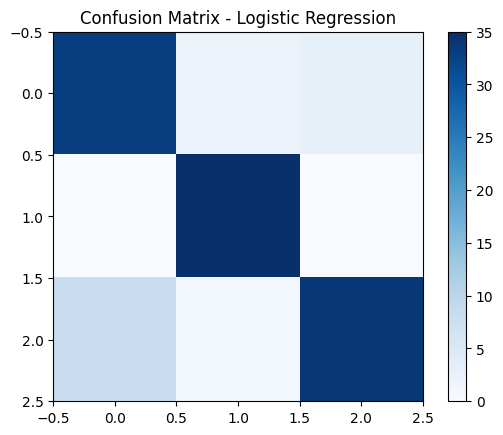

In [41]:
# Define the pipeline with Logistic Regression
logreg_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Train the Logistic Regression model
logreg_clf.fit(train_data, train_labels)

# Make predictions using Logistic Regression
logreg_predictions = logreg_clf.predict(test_data)

# Evaluate the Logistic Regression model
logreg_accuracy = accuracy_score(test_labels, logreg_predictions)
logreg_classification_report_str = classification_report(test_labels, logreg_predictions)
logreg_conf_matrix = confusion_matrix(test_labels, logreg_predictions)

# Print results for Logistic Regression
print('Logistic Regression Results:')
print(f'Accuracy: {logreg_accuracy:.2f}')
print('Classification Report:\n', logreg_classification_report_str)
print('Confusion Matrix:\n', logreg_conf_matrix)

# Visualize Confusion Matrix for Logistic Regression (Optional)
plt.imshow(logreg_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
plt.show()



Support Vector Machine (SVM) Results:
Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.89      0.85        38
         1.0       1.00      1.00      1.00        35
         2.0       0.90      0.81      0.85        43

    accuracy                           0.90       116
   macro avg       0.90      0.90      0.90       116
weighted avg       0.90      0.90      0.90       116

Confusion Matrix:
 [[34  0  4]
 [ 0 35  0]
 [ 8  0 35]]


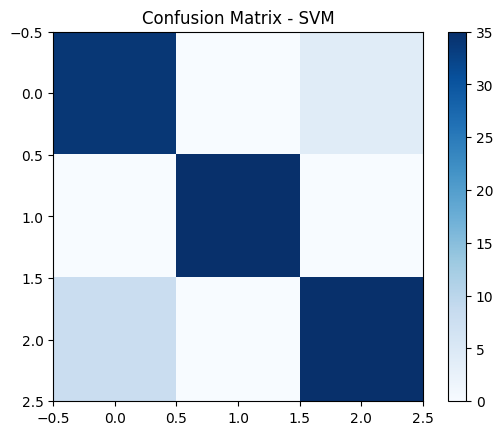

In [42]:
# Define the pipeline with Support Vector Machine (SVM)
svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

# Train the SVM model
svm_clf.fit(train_data, train_labels)

# Make predictions using SVM
svm_predictions = svm_clf.predict(test_data)

# Evaluate the SVM model
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_classification_report_str = classification_report(test_labels, svm_predictions)
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)

# Print results for SVM
print('\nSupport Vector Machine (SVM) Results:')
print(f'Accuracy: {svm_accuracy:.2f}')
print('Classification Report:\n', svm_classification_report_str)
print('Confusion Matrix:\n', svm_conf_matrix)

# Visualize Confusion Matrix for SVM (Optional)
plt.imshow(svm_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVM')
plt.colorbar()
plt.show()



k-Nearest Neighbors (k-NN) Results:
Accuracy: 0.66
Classification Report:
               precision    recall  f1-score   support

         0.0       0.49      0.95      0.65        38
         1.0       0.93      0.77      0.84        35
         2.0       0.93      0.30      0.46        43

    accuracy                           0.66       116
   macro avg       0.78      0.67      0.65       116
weighted avg       0.79      0.66      0.64       116

Confusion Matrix:
 [[36  1  1]
 [ 8 27  0]
 [29  1 13]]


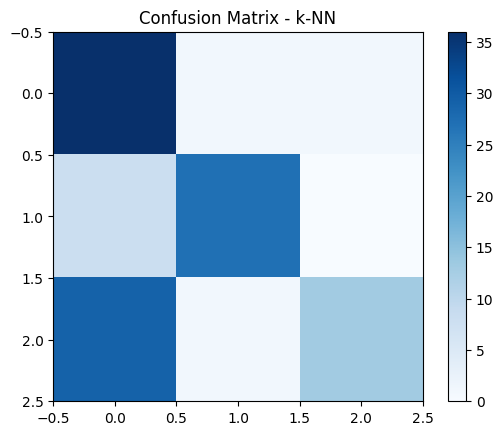

In [43]:
# Define the pipeline with k-Nearest Neighbors (k-NN)
knn_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])

# Train the k-NN model
knn_clf.fit(train_data, train_labels)

# Make predictions using k-NN
knn_predictions = knn_clf.predict(test_data)

# Evaluate the k-NN model
knn_accuracy = accuracy_score(test_labels, knn_predictions)
knn_classification_report_str = classification_report(test_labels, knn_predictions)
knn_conf_matrix = confusion_matrix(test_labels, knn_predictions)

# Print results for k-NN
print('\nk-Nearest Neighbors (k-NN) Results:')
print(f'Accuracy: {knn_accuracy:.2f}')
print('Classification Report:\n', knn_classification_report_str)
print('Confusion Matrix:\n', knn_conf_matrix)

# Visualize Confusion Matrix for k-NN (Optional)
plt.imshow(knn_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - k-NN')
plt.colorbar()
plt.show()



Random Forest Results:
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        38
         1.0       1.00      1.00      1.00        35
         2.0       0.92      0.81      0.86        43

    accuracy                           0.91       116
   macro avg       0.91      0.91      0.91       116
weighted avg       0.91      0.91      0.91       116

Confusion Matrix:
 [[35  0  3]
 [ 0 35  0]
 [ 8  0 35]]


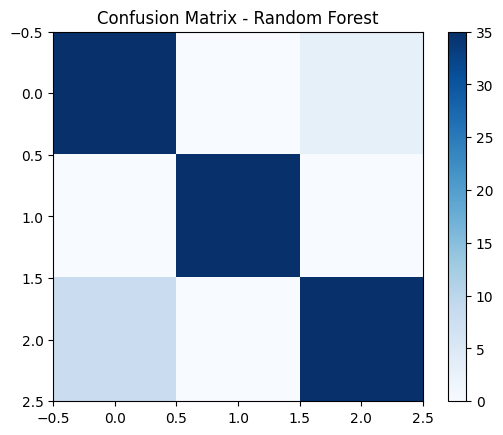

In [44]:
# Define the pipeline with Random Forest
rf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# Train the Random Forest model
rf_clf.fit(train_data, train_labels)

# Make predictions using Random Forest
rf_predictions = rf_clf.predict(test_data)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(test_labels, rf_predictions)
rf_classification_report_str = classification_report(test_labels, rf_predictions)
rf_conf_matrix = confusion_matrix(test_labels, rf_predictions)

# Print results for Random Forest
print('\nRandom Forest Results:')
print(f'Accuracy: {rf_accuracy:.2f}')
print('Classification Report:\n', rf_classification_report_str)
print('Confusion Matrix:\n', rf_conf_matrix)

# Visualize Confusion Matrix for Random Forest (Optional)
plt.imshow(rf_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
plt.show()


Multinomial Naive Bayes Results:
Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.79      0.82        38
         1.0       0.83      1.00      0.91        35
         2.0       0.90      0.81      0.85        43

    accuracy                           0.86       116
   macro avg       0.86      0.87      0.86       116
weighted avg       0.86      0.86      0.86       116

Confusion Matrix:
 [[30  4  4]
 [ 0 35  0]
 [ 5  3 35]]


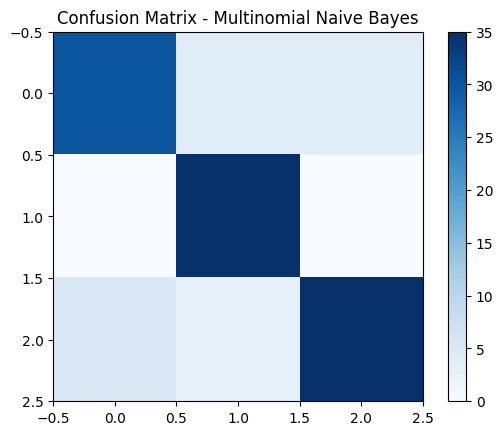

In [45]:
# Define the pipeline with Multinomial Naive Bayes (as a baseline)
nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Train the Multinomial Naive Bayes model
nb_clf.fit(train_data, train_labels)

# Make predictions using Multinomial Naive Bayes
nb_predictions = nb_clf.predict(test_data)

# Evaluate the Multinomial Naive Bayes model
nb_accuracy = accuracy_score(test_labels, nb_predictions)
nb_classification_report_str = classification_report(test_labels, nb_predictions)
nb_conf_matrix = confusion_matrix(test_labels, nb_predictions)

# Print results for Multinomial Naive Bayes
print('\nMultinomial Naive Bayes Results:')
print(f'Accuracy: {nb_accuracy:.2f}')
print('Classification Report:\n', nb_classification_report_str)
print('Confusion Matrix:\n', nb_conf_matrix)

# Visualize Confusion Matrix for Multinomial Naive Bayes (Optional)
plt.imshow(nb_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.colorbar()
plt.show()

In [47]:
pip install xgboost lightgbm scikit-learn


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 1.4 MB/s eta 0:01:09
   ---------------------------------------- 0.1/99.8 MB 1.4 MB/s eta 0:01:09
   ---------------------------------------- 0.2/99.8 MB 1.2 MB/s eta 0:01:25
   ---------------------------------------- 0.3/99.8 MB 1.3 MB/s eta 0:01:16
   ---------------------------------------- 0.4/99.8 MB 1.5 MB/s eta 0:01:07
   ---------------------------------------- 0.4/99.8 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.4/99.8 MB 1.4 MB/s eta 0:01:09
   ---------------------------------------- 0.5/99.8 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.6/99.8 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.7/99.8 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.7/99.8 MB 1.5 MB/s eta 0:01:06
   ----------

In [49]:
pip install transformers scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.



Ensemble Model Results:
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        38
         1.0       1.00      1.00      1.00        35
         2.0       0.90      0.86      0.88        43

    accuracy                           0.91       116
   macro avg       0.92      0.92      0.92       116
weighted avg       0.91      0.91      0.91       116

Confusion Matrix:
 [[34  0  4]
 [ 0 35  0]
 [ 6  0 37]]


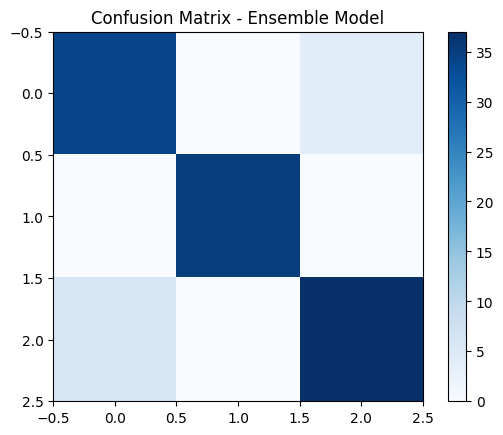

In [53]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Assuming you have train_data, train_labels, test_data, test_labels

# Define the pipeline with RandomForest and XGBoost as ensemble classifiers
ensemble_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42))
    ], voting='soft'))
])

# Train the ensemble model
ensemble_clf.fit(train_data, train_labels)

# Make predictions using the ensemble model
ensemble_predictions = ensemble_clf.predict(test_data)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(test_labels, ensemble_predictions)
ensemble_classification_report_str = classification_report(test_labels, ensemble_predictions)
ensemble_conf_matrix = confusion_matrix(test_labels, ensemble_predictions)

# Print results for the ensemble model
print('\nEnsemble Model Results:')
print(f'Accuracy: {ensemble_accuracy:.2f}')
print('Classification Report:\n', ensemble_classification_report_str)
print('Confusion Matrix:\n', ensemble_conf_matrix)

# Visualize Confusion Matrix for the ensemble model (Optional)
plt.imshow(ensemble_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Ensemble Model')
plt.colorbar()
plt.show()


In [1]:
# from transformers import BertTokenizer, BertForSequenceClassification
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import torch

# # Assuming you have train_data, train_labels, test_data, test_labels

# # Define the number of classes based on your specific task
# num_classes = 3  # Adjust this based on your task

# # Create a separate BERT model
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize the training data
# train_data_tokenized = tokenizer(train_data, padding=True, truncation=True, return_tensors='pt', max_length=512, add_special_tokens=True)

# # Convert labels to tensor
# train_labels_tensor = torch.tensor(train_labels)

# # Train the BERT model
# train_outputs = bert_model(**train_data_tokenized, labels=train_labels_tensor)
# loss = train_outputs.loss
# loss.backward()

# # Now, you can use the BERT model along with the scikit-learn pipeline for predictions
# # ...

# # Example:
# # Tokenize and make predictions using BERT on test data
# test_data_tokenized = tokenizer(test_data, padding=True, truncation=True, return_tensors='pt', max_length=512, add_special_tokens=True)
# bert_predictions = bert_model(**test_data_tokenized).logits.argmax(axis=1).numpy()

# # Evaluate the BERT model
# bert_accuracy = accuracy_score(test_labels, bert_predictions)
# bert_classification_report_str = classification_report(test_labels, bert_predictions)
# bert_conf_matrix = confusion_matrix(test_labels, bert_predictions)

# # Print results for BERT
# print('\nBERT Model Results:')
# print(f'Accuracy: {bert_accuracy:.2f}')
# print('Classification Report:\n', bert_classification_report_str)
# print('Confusion Matrix:\n', bert_conf_matrix)

# # Visualize Confusion Matrix for BERT (Optional)
# plt.imshow(bert_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - BERT Model')
# plt.colorbar()
# plt.show()


In [64]:
pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import DataLoader, Dataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# import torch
# from tqdm import tqdm

#  # Replace 'path/to/pocketguard.csv' with the actual path

# # Extract text and labels from the DataFrame
# texts = df['Full_Review'].astype(str).tolist()
# labels = df['Label'].tolist()

# # Encode labels
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)

# # Split data into training and validation sets
# train_texts, val_texts, train_labels, val_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# # Define custom dataset class
# class CustomDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = str(self.texts[idx])
#         label = torch.tensor(self.labels[idx], dtype=torch.long)

#         encoding = self.tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             return_token_type_ids=False,
#             padding="max_length",
#             truncation=True,
#             return_attention_mask=True,
#             return_tensors="pt",
#         )

#         return {
#             "text": text,
#             "input_ids": encoding["input_ids"].flatten(),
#             "attention_mask": encoding["attention_mask"].flatten(),
#             "label": label,
#         }

# # Tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))  # Adjust num_labels based on the number of unique labels

# # Hyperparameters
# batch_size = 8
# max_len = 64
# lr = 2e-5
# epochs = 3

# # Create datasets and dataloaders
# train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len)
# val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Optimizer and loss function
# optimizer = AdamW(model.parameters(), lr=lr)
# criterion = torch.nn.CrossEntropyLoss()

# # Training loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0

#     for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["label"].to(device)

#         optimizer.zero_grad()

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         train_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     avg_train_loss = train_loss / len(train_dataloader)

#     # Validation
#     model.eval()
#     val_loss = 0.0

#     with torch.no_grad():
#         for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} Validation"):
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["label"].to(device)

#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(val_dataloader)

#     print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

# # Save the trained model
# model.save_pretrained("path/to/save/model")
# tokenizer.save_pretrained("path/to/save/tokenizer")


In [3]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # ... (previous code)

# # Evaluate on the validation set
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in tqdm(val_dataloader, desc="Evaluating"):
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["label"].to(device)

#         outputs = model(input_ids, attention_mask=attention_mask)
#         logits = outputs.logits

#         preds = torch.argmax(logits, dim=1).cpu().numpy()
#         labels = labels.cpu().numpy()

#         all_preds.extend(preds)
#         all_labels.extend(labels)

# # Convert label indices back to original labels
# predicted_labels = label_encoder.inverse_transform(all_preds)
# true_labels = label_encoder.inverse_transform(all_labels)

# # Calculate and print accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Print classification report
# print("Classification Report:\n", classification_report(true_labels, predicted_labels))

# # Confusion matrix visualization
# conf_mat = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)

# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
